Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
city_data = pd.read_csv('../data/vancouver_bike_stations.csv')
foursquare_data = pd.read_csv('../data/foursquare_data.csv')
yelp_data = pd.read_csv('../data/yelp_data.csv')

Take a look at the data


In [3]:
city_data.head()

,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,latitude,longitude,timestamp,Unique ID
0,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,2024-10-17T23:52:11.082579Z,92
1,St George & Broadway,14,0,0,0,49.262321,-123.093060,2024-10-17T23:52:11.118473Z,248
2,Britannia Parking Lot,13,1,1,0,49.275882,-123.071865,2024-10-17T23:52:11.117617Z,232
3,Morton & Denman,6,19,0,19,49.288030,-123.142135,2024-10-17T23:52:11.058924Z,31
4,Thornton & National,10,4,0,4,49.273777,-123.092723,2024-10-17T23:52:11.117687Z,233


In [4]:
foursquare_data.head()

,name,fsq_id,categories,distance,address,latitude,longitude
0,Kingyo Izakaya 金魚居酒屋,4aa7455df964a5208e4c20e3,"Sushi Restaurant, Tapas Restaurant",306,"871 Denman St (btwn Haro & Barclay), Vancouver...",49.290643,-123.136956
1,Kim's Mart,4cb12e67c5e6a1cdbbf3dbf6,Import and Export Service,51,"511E Broadway E, Vancouver BC V5T 1X4",49.262642,-123.092549
2,East Vancouver Brewing Co,59f2476c65cdf8641b5f85f7,Brewery,116,"1675 Venables St, Vancouver BC V5L 2H1",49.276863,-123.071283
3,A-maze-ing Laughter,4c1823da834e2d7f0a812880,Sculpture Garden,65,"1800 Morton Ave (at Denman), Vancouver BC",49.287891,-123.142143
4,Beta5 Chocolates,4e8df4ccbe7bc43c1895944d,"Chocolate Store, Grocery Store",487,"413 Industrial Ave (at Station St), Vancouver ...",49.269893,-123.095842


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [5]:
yelp_data.head()

,name,yelp_id,categories,rating,address,latitude,longitude,price,review_count,is_closed,distance
0,Kingyo,crM1idgY_glhtxXT5kERNg,"Japanese, Tapas/Small Plates",4.4,"['871 Denman Street', 'Vancouver, BC V6G 2L9',...",49.290739,-123.137050,$$,1204,False,295.776312
1,The Farmhouse,WZz3gI0V6hN9M_cpeyo9Jg,"Italian, Wine Bars",4.3,"['352 East 10th Avenue', 'Vancouver, BC V5T 1Z...",49.261859,-123.097108,NaN,28,False,298.181441
2,Lunch Lady,9Waotz-_G9woVPWZTmZcwA,Vietnamese,4.1,"['1046 Commercial Drive', 'Vancouver, BC V5L 3...",49.274970,-123.069150,$$,261,False,208.568304
3,Kingyo,crM1idgY_glhtxXT5kERNg,"Japanese, Tapas/Small Plates",4.4,"['871 Denman Street', 'Vancouver, BC V6G 2L9',...",49.290739,-123.137050,$$,1204,False,476.172764
4,Phnom Penh,yeNenSjz_HCqngGFU5d8NQ,"Cambodian, Vietnamese",4.2,"['244 E Georgia Street', 'Vancouver, BC V6A 1Z...",49.278431,-123.098205,$$,1775,False,652.660730


Join the data

In [6]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two coordinate points (in meters)
    """
    R = 6371000  # Earth's radius in meters
    
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def find_nearest_pois(city_row, poi_data, max_distance=1000):
    """
    Find the nearest POIs (Foursquare or Yelp data points) for a given city data row
    """
    distances = []
    
    for _, poi_row in poi_data.iterrows():
        distance = haversine_distance(city_row['latitude'], city_row['longitude'],
                                      poi_row['latitude'], poi_row['longitude'])
        if distance <= max_distance:
            distances.append((distance, poi_row))
    
    # Sort by distance and return top N
    return sorted(distances, key=lambda x: x[0])

# Create result DataFrame
result_data = []

# Iterate through city data
for _, city_row in city_data.iterrows():
    # Find the nearest Foursquare POIs
    nearest_foursquares = find_nearest_pois(city_row, foursquare_data)
    
    # Find the nearest Yelp POIs
    nearest_yelps = find_nearest_pois(city_row, yelp_data)
    
    # Create base result row for this station
    base_row = {
        'Station Name': city_row['Station Name'],
        'empty_slots': city_row['empty_slots'],
        'free_bikes': city_row['free_bikes'],
        'ebikes': city_row['ebikes'],
        'normal_bikes': city_row['normal_bikes'],
        'station_latitude': city_row['latitude'],
        'station_longitude': city_row['longitude'],
        'Unique ID': city_row['Unique ID'],
    }
    
    # Add rows for Foursquare POIs
    for distance, poi in nearest_foursquares:
        row = base_row.copy()
        row.update({
            'poi_type': 'Foursquare',
            'poi_name': poi['name'],
            'poi_categories': poi['categories'],
            'poi_distance': distance,
            'poi_latitude': poi['latitude'],
            'poi_longitude': poi['longitude']
        })
        result_data.append(row)
    
    # Add rows for Yelp POIs
    for distance, poi in nearest_yelps:
        row = base_row.copy()
        row.update({
            'poi_type': 'Yelp',
            'poi_name': poi['name'],
            'poi_categories': poi['categories'],
            'poi_distance': distance,
            'poi_latitude': poi['latitude'],
            'poi_longitude': poi['longitude'],
            'poi_rating': poi['rating'],
            'poi_price': poi['price'],
            'poi_review_count': poi['review_count']
        })
        result_data.append(row)

# Create final DataFrame
city_poi_data = pd.DataFrame(result_data)

# Display results
print(city_poi_data.shape)
city_poi_data.head(10)  # Show first 10 rows to see multiple POIs for a station

(11716, 17)


,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,station_latitude,station_longitude,Unique ID,poi_type,poi_name,poi_categories,poi_distance,poi_latitude,poi_longitude,poi_rating,poi_price,poi_review_count
0,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Peaked Pies,"Australian Restaurant, Comfort Food Restaurant...",299.295365,49.289640,-123.138493,NaN,NaN,NaN
1,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Kingyo Izakaya 金魚居酒屋,"Sushi Restaurant, Tapas Restaurant",306.685530,49.290643,-123.136956,NaN,NaN,NaN
2,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Kingyo Izakaya 金魚居酒屋,"Sushi Restaurant, Tapas Restaurant",306.685530,49.290643,-123.136956,NaN,NaN,NaN
3,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Tavola,Italian Restaurant,359.203855,49.291843,-123.135761,NaN,NaN,NaN
4,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Banana Leaf,Malay Restaurant,408.075251,49.288276,-123.139917,NaN,NaN,NaN
5,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Saku,Japanese Restaurant,431.788309,49.291333,-123.134825,NaN,NaN,NaN
6,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,A-maze-ing Laughter,Sculpture Garden,458.660378,49.287891,-123.142143,NaN,NaN,NaN
7,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,A-maze-ing Laughter,Sculpture Garden,458.660378,49.287891,-123.142143,NaN,NaN,NaN
8,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Stanley Park English Bay Seawall,Hiking Trail,478.845993,49.290133,-123.146728,NaN,NaN,NaN
9,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Foursquare,Eye Kandee Lingerie,"Clothing Store, Lingerie Store",650.452544,49.286089,-123.139811,NaN,NaN,NaN


Because foursquare data are included in the yelp data, I will drop the foursquare data



In [7]:
city_poi_data = city_poi_data.loc[city_poi_data['poi_type'] == 'Yelp']
city_poi_data.head(10)
# city_poi_data.shape

,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,station_latitude,station_longitude,Unique ID,poi_type,poi_name,poi_categories,poi_distance,poi_latitude,poi_longitude,poi_rating,poi_price,poi_review_count
21,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
22,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
23,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
24,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
25,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
26,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
27,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
28,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
29,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0
30,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.13705,4.4,$$,1204.0


Too many duplicates, let's drop them

In [8]:
city_poi_data_copy = city_poi_data.copy().drop_duplicates()
city_poi_data_copy.head(10)
# city_poi_data_copy.shape


,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,station_latitude,station_longitude,Unique ID,poi_type,poi_name,poi_categories,poi_distance,poi_latitude,poi_longitude,poi_rating,poi_price,poi_review_count
21,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Kingyo,"Japanese, Tapas/Small Plates",295.776641,49.290739,-123.137050,4.4,$$,1204.0
37,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Guu with Garlic,"Japanese, Tapas/Small Plates",533.286012,49.290249,-123.133814,4.3,$$,1081.0
40,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Saku,Japanese,681.537901,49.289223,-123.132266,4.4,$$,453.0
41,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Cardero's Restaurant & Marine Pub,"Seafood, Cajun/Creole, Canadian (New)",954.066407,49.291456,-123.127576,3.9,$$$,715.0
43,Chilco & Barclay,9,9,2,7,49.291909,-123.140713,92,Yelp,Forage,"Canadian (New), Breakfast & Brunch",990.293300,49.287070,-123.129250,4.1,$$,736.0
74,St George & Broadway,14,0,0,0,49.262321,-123.093060,248,Yelp,The Farmhouse,"Italian, Wine Bars",298.181772,49.261859,-123.097108,4.3,NaN,28.0
78,St George & Broadway,14,0,0,0,49.262321,-123.093060,248,Yelp,Fassil Ethiopian Restaurant,Ethiopian,343.178746,49.262317,-123.088331,4.3,$$,154.0
84,St George & Broadway,14,0,0,0,49.262321,-123.093060,248,Yelp,Nemesis Coffee,"Coffee & Tea, Breakfast & Brunch, Desserts",525.640551,49.267041,-123.092655,4.2,$$,101.0
85,St George & Broadway,14,0,0,0,49.262321,-123.093060,248,Yelp,Osteria Savio Volpe,Italian,558.752048,49.257491,-123.090934,4.2,$$$,463.0
88,St George & Broadway,14,0,0,0,49.262321,-123.093060,248,Yelp,Les Faux Bourgeois,"French, Cafes",609.199964,49.257281,-123.089767,3.9,$$,485.0


Looks good, Let's drop the unuseful columns



In [9]:
city_poi_data_copy = city_poi_data_copy.drop(columns=['station_latitude', 'station_longitude', 'poi_categories', 'Unique ID','poi_type'])
city_poi_data_copy.head(10)
# city_poi_data_copy.shape

,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,poi_name,poi_distance,poi_latitude,poi_longitude,poi_rating,poi_price,poi_review_count
21,Chilco & Barclay,9,9,2,7,Kingyo,295.776641,49.290739,-123.137050,4.4,$$,1204.0
37,Chilco & Barclay,9,9,2,7,Guu with Garlic,533.286012,49.290249,-123.133814,4.3,$$,1081.0
40,Chilco & Barclay,9,9,2,7,Saku,681.537901,49.289223,-123.132266,4.4,$$,453.0
41,Chilco & Barclay,9,9,2,7,Cardero's Restaurant & Marine Pub,954.066407,49.291456,-123.127576,3.9,$$$,715.0
43,Chilco & Barclay,9,9,2,7,Forage,990.293300,49.287070,-123.129250,4.1,$$,736.0
74,St George & Broadway,14,0,0,0,The Farmhouse,298.181772,49.261859,-123.097108,4.3,NaN,28.0
78,St George & Broadway,14,0,0,0,Fassil Ethiopian Restaurant,343.178746,49.262317,-123.088331,4.3,$$,154.0
84,St George & Broadway,14,0,0,0,Nemesis Coffee,525.640551,49.267041,-123.092655,4.2,$$,101.0
85,St George & Broadway,14,0,0,0,Osteria Savio Volpe,558.752048,49.257491,-123.090934,4.2,$$$,463.0
88,St George & Broadway,14,0,0,0,Les Faux Bourgeois,609.199964,49.257281,-123.089767,3.9,$$,485.0


Let's rename the columns



In [10]:
city_poi_data_copy = city_poi_data_copy.rename(columns={'poi_name':'name', 'poi_rating':'rating', 'poi_price':'price', 'poi_review_count':'review_count','poi_distance':'distance'})
city_poi_data_copy.head(10)
# city_poi_data_copy.shape

,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,name,distance,poi_latitude,poi_longitude,rating,price,review_count
21,Chilco & Barclay,9,9,2,7,Kingyo,295.776641,49.290739,-123.137050,4.4,$$,1204.0
37,Chilco & Barclay,9,9,2,7,Guu with Garlic,533.286012,49.290249,-123.133814,4.3,$$,1081.0
40,Chilco & Barclay,9,9,2,7,Saku,681.537901,49.289223,-123.132266,4.4,$$,453.0
41,Chilco & Barclay,9,9,2,7,Cardero's Restaurant & Marine Pub,954.066407,49.291456,-123.127576,3.9,$$$,715.0
43,Chilco & Barclay,9,9,2,7,Forage,990.293300,49.287070,-123.129250,4.1,$$,736.0
74,St George & Broadway,14,0,0,0,The Farmhouse,298.181772,49.261859,-123.097108,4.3,NaN,28.0
78,St George & Broadway,14,0,0,0,Fassil Ethiopian Restaurant,343.178746,49.262317,-123.088331,4.3,$$,154.0
84,St George & Broadway,14,0,0,0,Nemesis Coffee,525.640551,49.267041,-123.092655,4.2,$$,101.0
85,St George & Broadway,14,0,0,0,Osteria Savio Volpe,558.752048,49.257491,-123.090934,4.2,$$$,463.0
88,St George & Broadway,14,0,0,0,Les Faux Bourgeois,609.199964,49.257281,-123.089767,3.9,$$,485.0


Let combine the poi_latitude and poi_longitude with the to one columns



In [11]:
# Create poi_location column with 2 decimal places
city_poi_data_copy['poi_location'] = city_poi_data_copy.apply(
    lambda row: f"({row['poi_latitude']:.2f}, {row['poi_longitude']:.2f})", 
    axis=1
)

# Drop the original poi_latitude and poi_longitude columns
city_poi_data_copy = city_poi_data_copy.drop(columns=['poi_latitude', 'poi_longitude'])

# Display the first 20 rows of the updated dataframe
print(city_poi_data_copy.head(20))



              Station Name  empty_slots  free_bikes  ebikes  normal_bikes  \
21        Chilco & Barclay            9           9       2             7   
37        Chilco & Barclay            9           9       2             7   
40        Chilco & Barclay            9           9       2             7   
41        Chilco & Barclay            9           9       2             7   
43        Chilco & Barclay            9           9       2             7   
74    St George & Broadway           14           0       0             0   
78    St George & Broadway           14           0       0             0   
84    St George & Broadway           14           0       0             0   
85    St George & Broadway           14           0       0             0   
88    St George & Broadway           14           0       0             0   
89    St George & Broadway           14           0       0             0   
93    St George & Broadway           14           0       0             0   

Let clean data, the distance value could be integer,we can round it to the nearest integer

In [12]:
city_poi_data_copy['distance'] = city_poi_data_copy['distance'].round(0)
city_poi_data_copy.head(20)


,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,name,distance,rating,price,review_count,poi_location
21,Chilco & Barclay,9,9,2,7,Kingyo,296.0,4.4,$$,1204.0,"(49.29, -123.14)"
37,Chilco & Barclay,9,9,2,7,Guu with Garlic,533.0,4.3,$$,1081.0,"(49.29, -123.13)"
40,Chilco & Barclay,9,9,2,7,Saku,682.0,4.4,$$,453.0,"(49.29, -123.13)"
41,Chilco & Barclay,9,9,2,7,Cardero's Restaurant & Marine Pub,954.0,3.9,$$$,715.0,"(49.29, -123.13)"
43,Chilco & Barclay,9,9,2,7,Forage,990.0,4.1,$$,736.0,"(49.29, -123.13)"
74,St George & Broadway,14,0,0,0,The Farmhouse,298.0,4.3,NaN,28.0,"(49.26, -123.10)"
78,St George & Broadway,14,0,0,0,Fassil Ethiopian Restaurant,343.0,4.3,$$,154.0,"(49.26, -123.09)"
84,St George & Broadway,14,0,0,0,Nemesis Coffee,526.0,4.2,$$,101.0,"(49.27, -123.09)"
85,St George & Broadway,14,0,0,0,Osteria Savio Volpe,559.0,4.2,$$$,463.0,"(49.26, -123.09)"
88,St George & Broadway,14,0,0,0,Les Faux Bourgeois,609.0,3.9,$$,485.0,"(49.26, -123.09)"


The price column is not proper for building the model, let's transform it into a categorical variable

In [13]:
city_poi_data_copy['price'] = city_poi_data_copy['price'].astype('category')
city_poi_data_copy.head(20)


,Station Name,empty_slots,free_bikes,ebikes,normal_bikes,name,distance,rating,price,review_count,poi_location
21,Chilco & Barclay,9,9,2,7,Kingyo,296.0,4.4,$$,1204.0,"(49.29, -123.14)"
37,Chilco & Barclay,9,9,2,7,Guu with Garlic,533.0,4.3,$$,1081.0,"(49.29, -123.13)"
40,Chilco & Barclay,9,9,2,7,Saku,682.0,4.4,$$,453.0,"(49.29, -123.13)"
41,Chilco & Barclay,9,9,2,7,Cardero's Restaurant & Marine Pub,954.0,3.9,$$$,715.0,"(49.29, -123.13)"
43,Chilco & Barclay,9,9,2,7,Forage,990.0,4.1,$$,736.0,"(49.29, -123.13)"
74,St George & Broadway,14,0,0,0,The Farmhouse,298.0,4.3,NaN,28.0,"(49.26, -123.10)"
78,St George & Broadway,14,0,0,0,Fassil Ethiopian Restaurant,343.0,4.3,$$,154.0,"(49.26, -123.09)"
84,St George & Broadway,14,0,0,0,Nemesis Coffee,526.0,4.2,$$,101.0,"(49.27, -123.09)"
85,St George & Broadway,14,0,0,0,Osteria Savio Volpe,559.0,4.2,$$$,463.0,"(49.26, -123.09)"
88,St George & Broadway,14,0,0,0,Les Faux Bourgeois,609.0,3.9,$$,485.0,"(49.26, -123.09)"


Save it as a csv file, this is important for building the database and model



In [14]:
city_poi_data_copy.to_csv('../data/city_poi_data.csv', index=False)

# Data visualization
## 1. The distribution of free bikes and empty slots




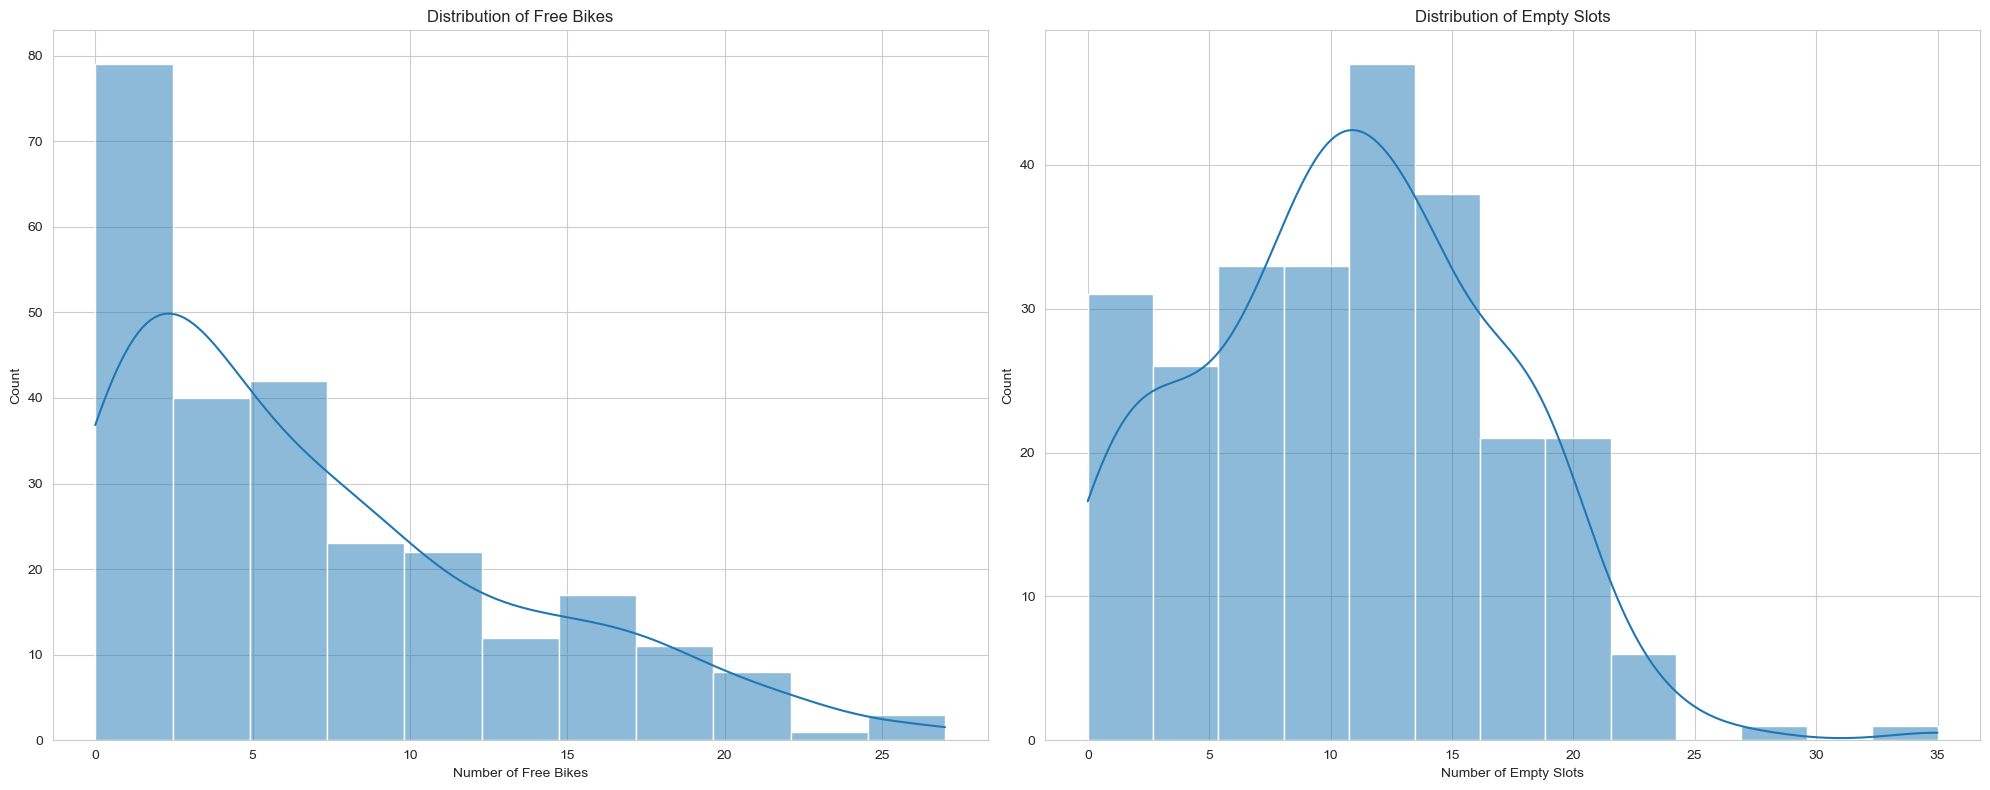

In [15]:
# Set the style for seaborn plots
sns.set_style("whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Changed to 1x2 grid

# Histogram of free bikes
sns.histplot(data=city_data, x='free_bikes', kde=True, ax=axes[0])  # Changed to axes[0]
axes[0].set_title('Distribution of Free Bikes')
axes[0].set_xlabel('Number of Free Bikes')

# Histogram of empty slots
sns.histplot(data=city_data, x='empty_slots', kde=True, ax=axes[1])  # Changed to axes[1]
axes[1].set_title('Distribution of Empty Slots')
axes[1].set_xlabel('Number of Empty Slots')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



## 2. Compare the normal bikes and ebikes


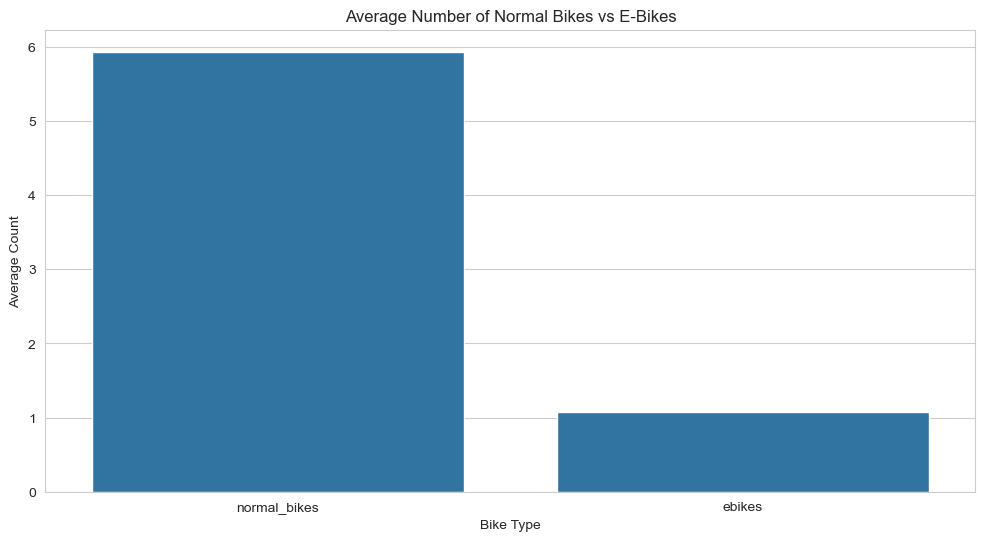

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create a grouped bar plot
bike_data = city_data[['normal_bikes', 'ebikes']].mean().reset_index()
bike_data.columns = ['bike_type', 'average_count']
sns.barplot(data=bike_data, x='bike_type', y='average_count', ax=ax)
ax.set_title('Average Number of Normal Bikes vs E-Bikes')
ax.set_xlabel('Bike Type')
ax.set_ylabel('Average Count')

plt.show()

## 3. The mean distance to the nearest business for each station




/var/folders/n9/j0dtm7bn7_56lrscncyljw6m0000gn/T/ipykernel_73191/1725752603.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top20, x='distance', y='Station Name', palette='viridis')


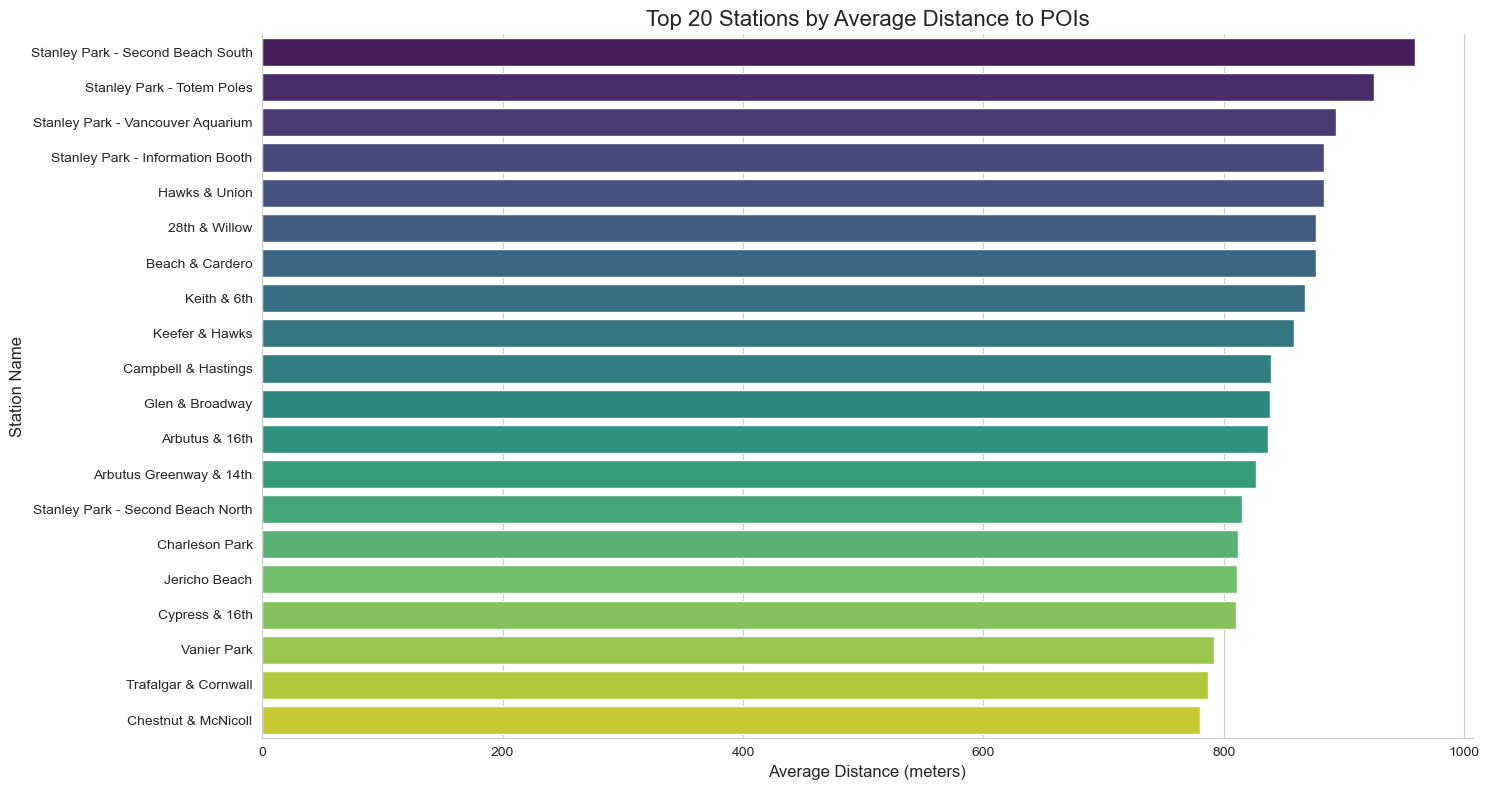

In [17]:
# Group the data and calculate mean distance
df = city_poi_data_copy.groupby('Station Name')['distance'].mean().reset_index().sort_values(by='distance', ascending=False)

# Select top 20 stations with highest average distance
df_top20 = df.head(20)

# Set up the matplotlib figure
plt.figure(figsize=(15, 8))

# Create the bar plot
sns.barplot(data=df_top20, x='distance', y='Station Name', palette='viridis')

# Customize the plot
plt.title('Top 20 Stations by Average Distance to POIs', fontsize=16)
plt.xlabel('Average Distance (meters)', fontsize=12)
plt.ylabel('Station Name', fontsize=12)

# Remove top and right spines
sns.despine()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



## 4. The distribution of the rate of the business


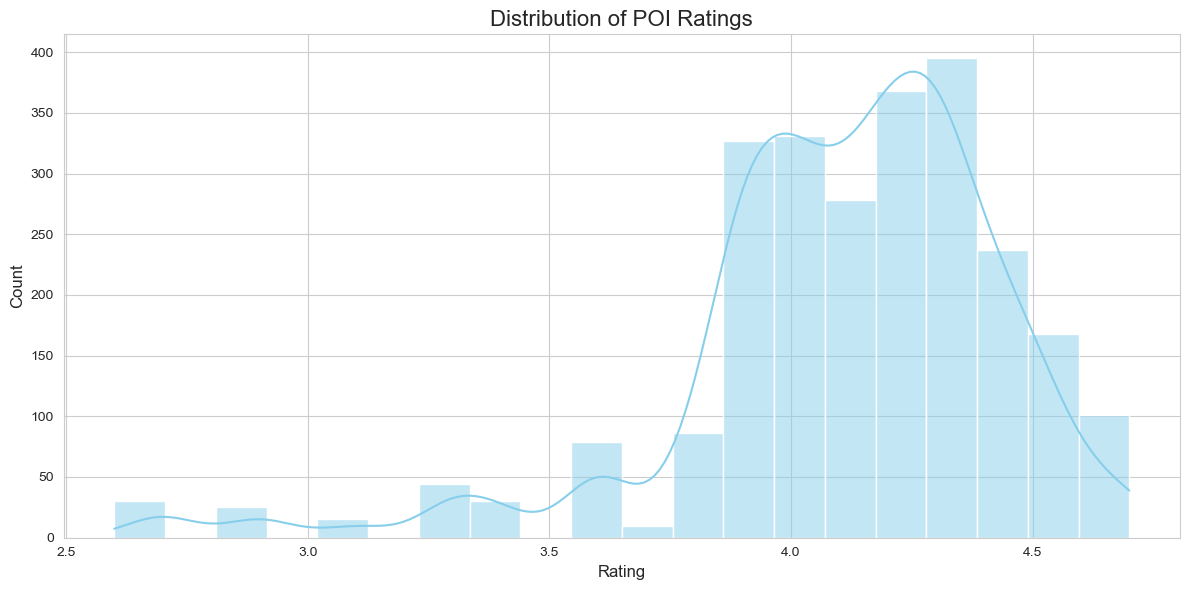

In [18]:
# Set the style for seaborn plots
sns.set_style("whitegrid")

# Create a figure
plt.figure(figsize=(12, 6))

# Plot the distribution of ratings
sns.histplot(data=city_poi_data_copy, x='rating', kde=True, color='skyblue', bins=20)

plt.title('Distribution of POI Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## 5. The ralation between the rating and number of stations near by


In [19]:
# Count the number of stations for each POI
poi_station_counts = city_poi_data_copy.groupby('poi_location')['Station Name'].nunique().reset_index()
poi_station_counts.columns = ['poi_location', 'station_count']

# Merge the counts back to the original dataframe
city_poi_data_copy = city_poi_data_copy.merge(poi_station_counts, on='poi_location', how='left')

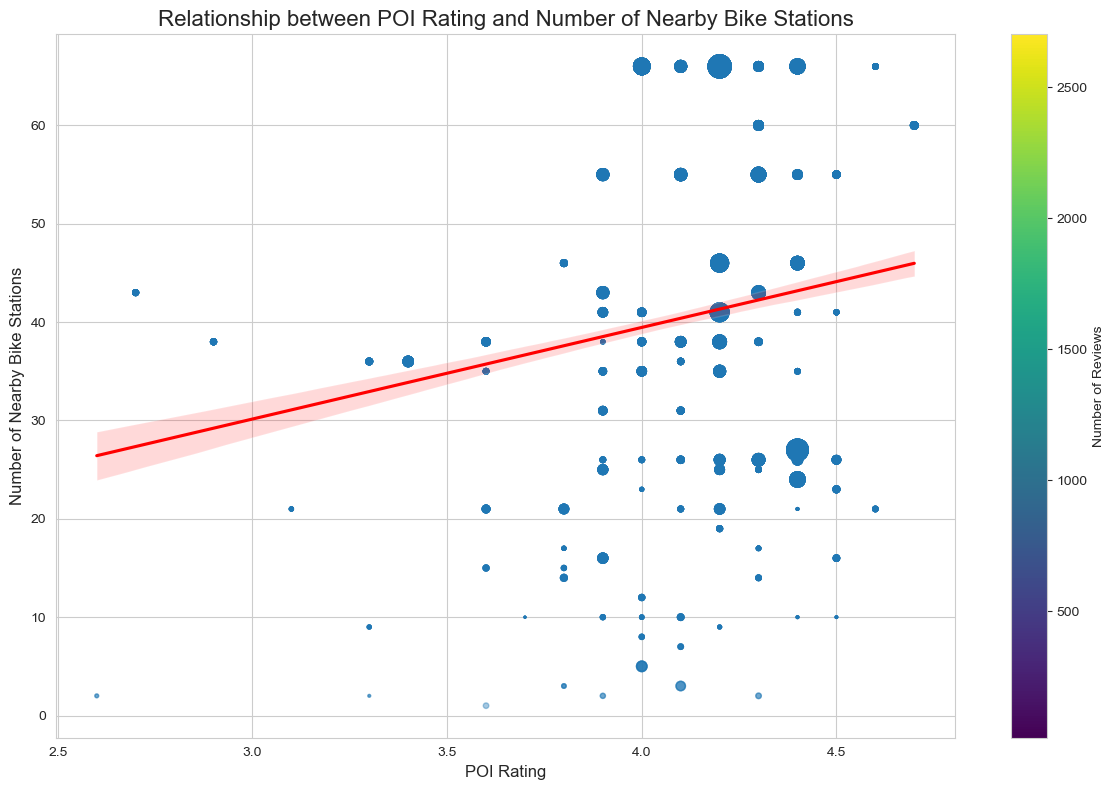

In [23]:
# Set the style and figure size
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create the scatter plot with regression line
scatter = sns.regplot(
    data=city_poi_data_copy, 
    x='rating', 
    y='station_count',
    scatter_kws={
        'alpha': 0.4,
        's': city_poi_data_copy['review_count'] / 10  # Adjust size based on review count
    },
    line_kws={'color': 'red'}
)

# Customize the plot
plt.title('Relationship between POI Rating and Number of Nearby Bike Stations', fontsize=16)
plt.xlabel('POI Rating', fontsize=12)
plt.ylabel('Number of Nearby Bike Stations', fontsize=12)

# Add a colorbar for the 'size' variable
norm = plt.Normalize(city_poi_data_copy['review_count'].min(), city_poi_data_copy['review_count'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label="Number of Reviews", ax=scatter.axes)
cbar.ax.tick_params(labelsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [21]:
# Add some statistical analysis (Just for fun)
correlation = city_poi_data_copy['rating'].corr(city_poi_data_copy['station_count'])
print(f"Correlation between rating and station_count: {correlation:.4f}")

Correlation between rating and station_count: 0.1850


Looks like the rating and the number of stations near by are positively correlated, which means the more reviews a business gets, the more stations near by. However, the correlation is not very strong, which means there maybe other factors that affect the number of stations near by.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [26]:
import sqlite3
import pandas as pd

# Specify the path for the SQLite database file
db_path = '/Users/kailiu/Statistical_Modelling_Project/data/project_database.sqlite'

# Create a connection to the SQLite database
conn = sqlite3.connect(db_path)

# Create and populate the bike_stations table
city_data_copy = city_data.copy()
city_data_copy['station_id'] = city_data_copy.index  # Create a unique identifier
city_data_copy.to_sql('bike_stations', conn, if_exists='replace', index=False)

# Create and populate the pois table
poi_data = city_poi_data_copy[['name', 'poi_location', 'rating', 'review_count', 'price']].drop_duplicates()
poi_data['poi_id'] = poi_data.index  # Create a unique identifier
poi_data.to_sql('pois', conn, if_exists='replace', index=False)

# Create and populate the station_poi_relations table
station_poi_relations = city_poi_data_copy[['Station Name', 'poi_location', 'distance']]
station_poi_relations = station_poi_relations.merge(city_data_copy[['Station Name', 'station_id']], on='Station Name')
station_poi_relations = station_poi_relations.merge(poi_data[['poi_location', 'poi_id']], on='poi_location')
station_poi_relations = station_poi_relations[['station_id', 'poi_id', 'distance']]
station_poi_relations.to_sql('station_poi_relations', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

print(f"Data has been successfully saved to {db_path}")



Data has been successfully saved to /Users/kailiu/Statistical_Modelling_Project/data/project_database.sqlite

First 5 rows from the bike_stations table:
            Station Name  empty_slots  free_bikes  ebikes  normal_bikes  \
0       Chilco & Barclay            9           9       2             7   
1   St George & Broadway           14           0       0             0   
2  Britannia Parking Lot           13           1       1             0   
3        Morton & Denman            6          19       0            19   
4    Thornton & National           10           4       0             4   

    latitude   longitude                    timestamp  Unique ID  station_id  
0  49.291909 -123.140713  2024-10-17T23:52:11.082579Z         92           0  
1  49.262321 -123.093060  2024-10-17T23:52:11.118473Z        248           1  
2  49.275882 -123.071865  2024-10-17T23:52:11.117617Z        232           2  
3  49.288030 -123.142135  2024-10-17T23:52:11.058924Z         31           3  
4

# Database Structure

Our database consists of three main tables:

## 1. bike_stations

Contains information about each bike station.

## 2. pois (Points of Interest)

Contains information about each Point of Interest.

## 3. station_poi_relations

A junction table that represents the many-to-many relationship between stations and POIs, including the distance between them.

Look at the data before and after the join to validate your data.

In [27]:
# Verify that the data was successfully saved
conn = sqlite3.connect(db_path)
for table in ['bike_stations', 'pois', 'station_poi_relations']:
    print(f"\nFirst 5 rows from the {table} table:")
    df_from_sql = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 5", conn)
    print(df_from_sql)
conn.close()


First 5 rows from the bike_stations table:
            Station Name  empty_slots  free_bikes  ebikes  normal_bikes  \
0       Chilco & Barclay            9           9       2             7   
1   St George & Broadway           14           0       0             0   
2  Britannia Parking Lot           13           1       1             0   
3        Morton & Denman            6          19       0            19   
4    Thornton & National           10           4       0             4   

    latitude   longitude                    timestamp  Unique ID  station_id  
0  49.291909 -123.140713  2024-10-17T23:52:11.082579Z         92           0  
1  49.262321 -123.093060  2024-10-17T23:52:11.118473Z        248           1  
2  49.275882 -123.071865  2024-10-17T23:52:11.117617Z        232           2  
3  49.288030 -123.142135  2024-10-17T23:52:11.058924Z         31           3  
4  49.273777 -123.092723  2024-10-17T23:52:11.117687Z        233           4  

First 5 rows from the pois tab